In [182]:
data=read.table("mcp.txt", header=TRUE, sep=",")
head(data)

age,sex,bmi,children,smoker,region,charges
19,female,27.900,0,yes,southwest,16884.924
18,male,33.770,1,no,southeast,1725.552
28,male,33.000,3,no,southeast,4449.462
33,male,22.705,0,no,northwest,21984.471
32,male,28.880,0,no,northwest,3866.855
31,female,25.740,0,no,southeast,3756.622


Dane zawierają w sobie informację o kosztach ubezpieczenia dla osób, a także wiek tych osób, płeć, bmi, ilość dzieci, czy dana osoba pali, i rejon, z której pochodzi. Chcemy stworzyć model, który umożliwi predykcję ksztów ubezpieczenia (charges) na podstawie danych w pliku mcp. txt

1. Charakterystyka numeryczna i graficzna

Zacznijmy od zmiennej charges:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


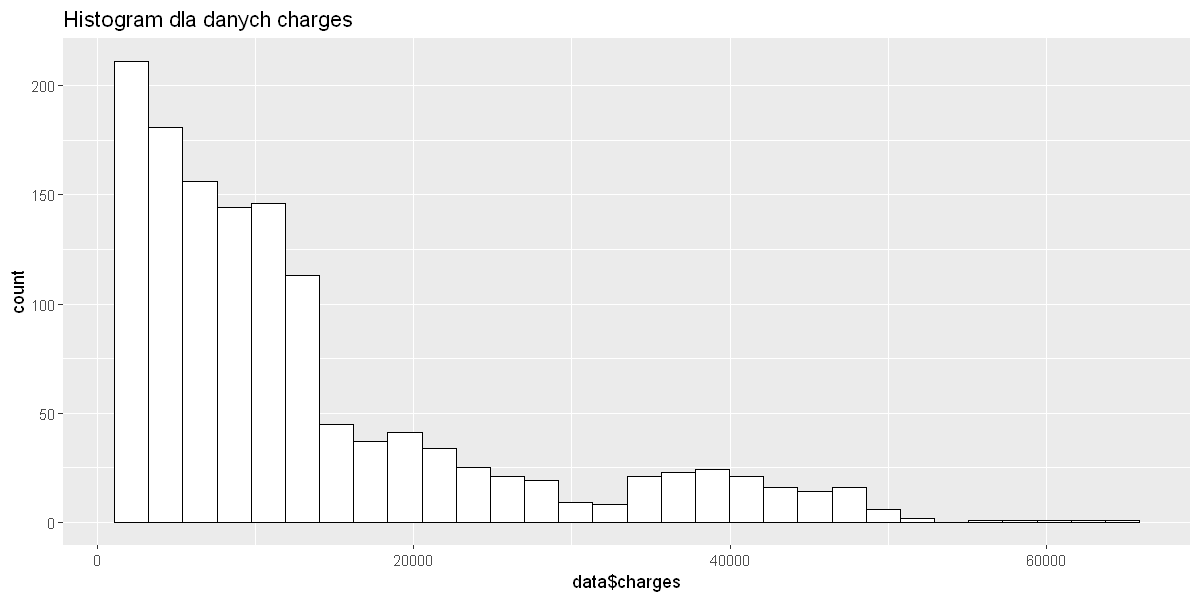

[1] 9382.033

[1] 146652372

[1] 12110.01

[1] 1121.874

[1] 63770.43

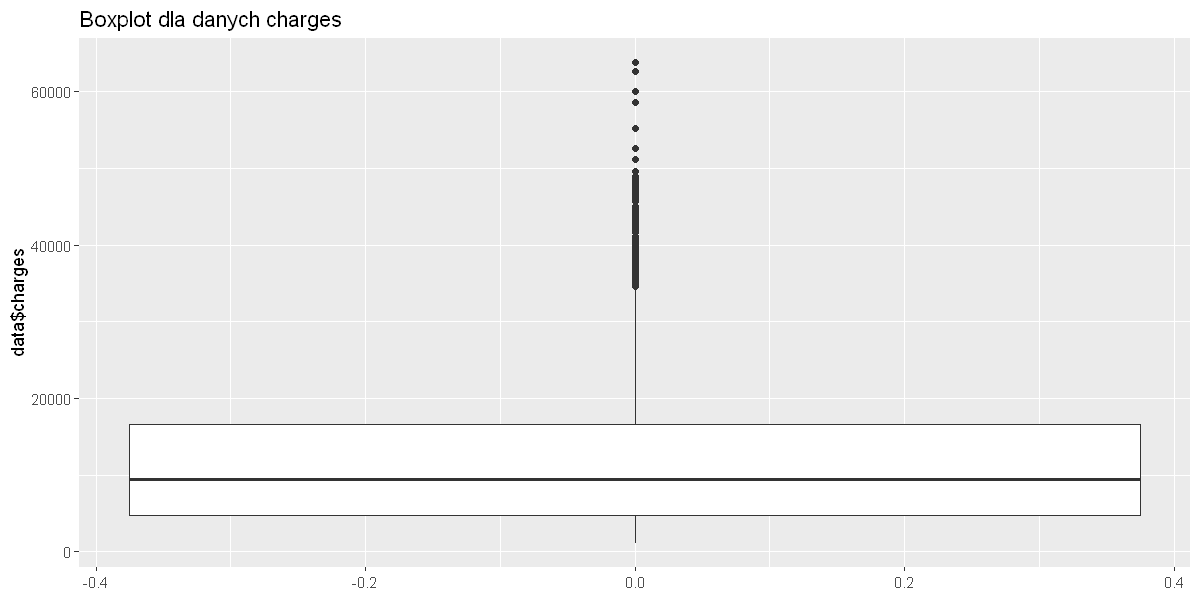

In [478]:
library(ggplot2)
histogram = ggplot(data, aes(data$charges)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych charges")
histogram
bp=ggplot(data, aes(y=data$charges)) + 
  geom_boxplot() + ggtitle("Boxplot dla danych charges")
bp
median(data$charges); var(data$charges); sd(data$charges); min(data$charges); max(data$charges)

[1] 0.06060606

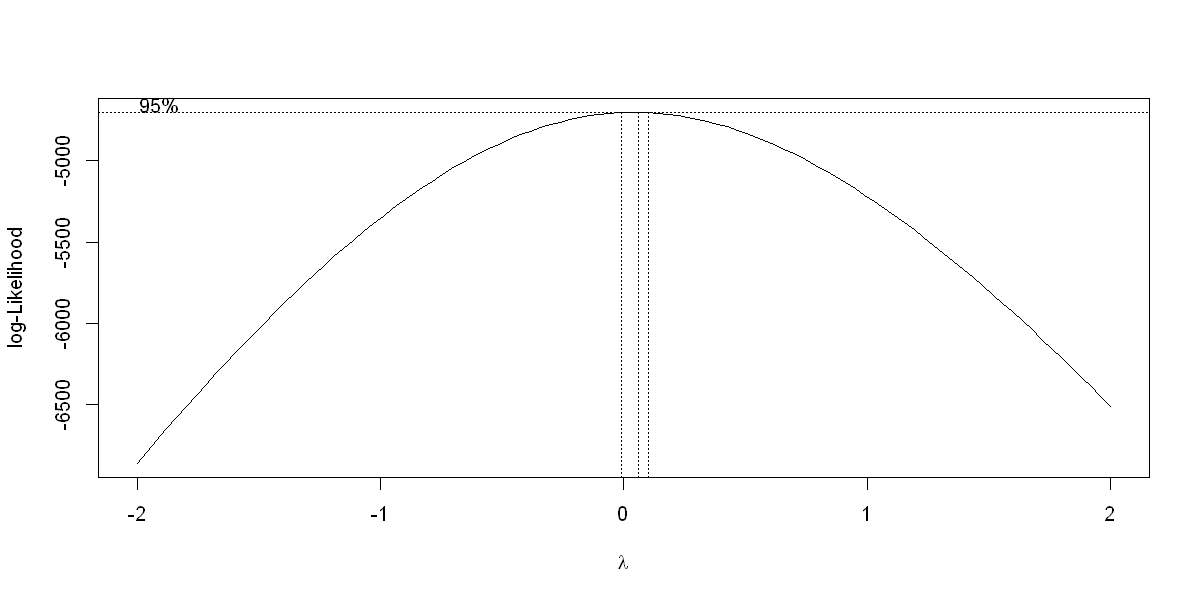

In [264]:
x=data$charges
library(MASS)
b=boxcox(lm(x ~ 1))
lambda <- b$x[which.max(b$y)]
lambda

Z powyższych wykresów widać, że dane charges nie należa do rozkładu normalnego, bardziej wygląda na to, że jest to rozkład wykładniczy. Mediana wynosi 9382.033, lecz dane posiadają bardzo dużą wariancję i odchylenie standardowe. Spróbujmy przekształcić te dane tak, aby miały rozkład normalny, stosują transformację logarytmiczną (ponieważ lambda wyszła bliska 0):

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


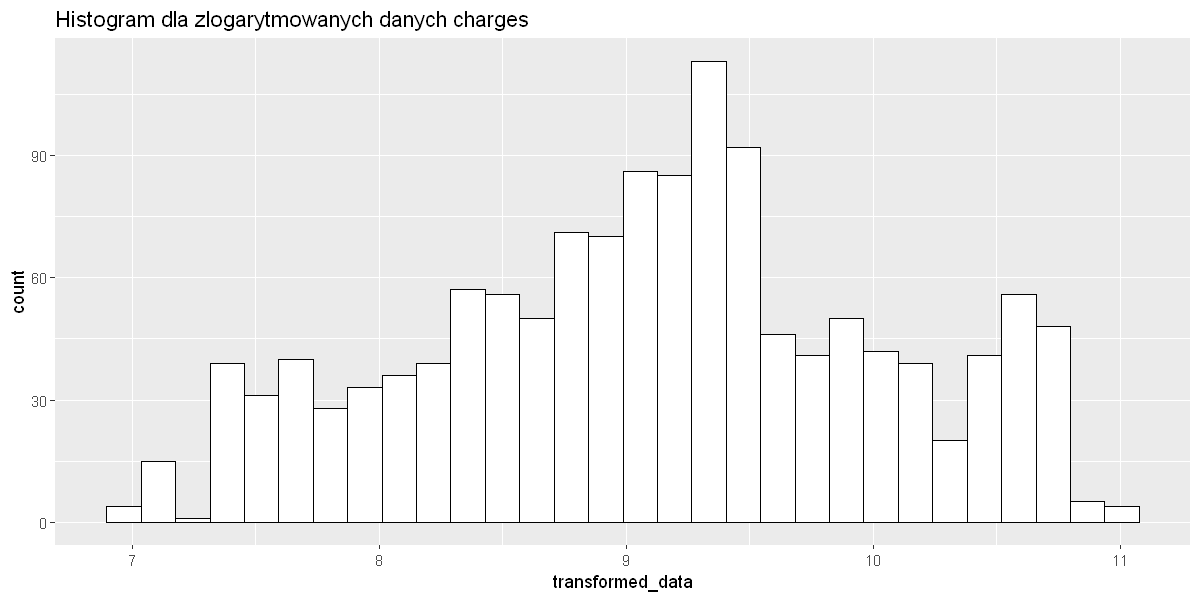


	Shapiro-Wilk normality test

data:  transformed_data
W = 0.98316, p-value = 2.291e-11



	Shapiro-Wilk normality test

data:  n
W = 0.98338, p-value = 2.843e-11


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


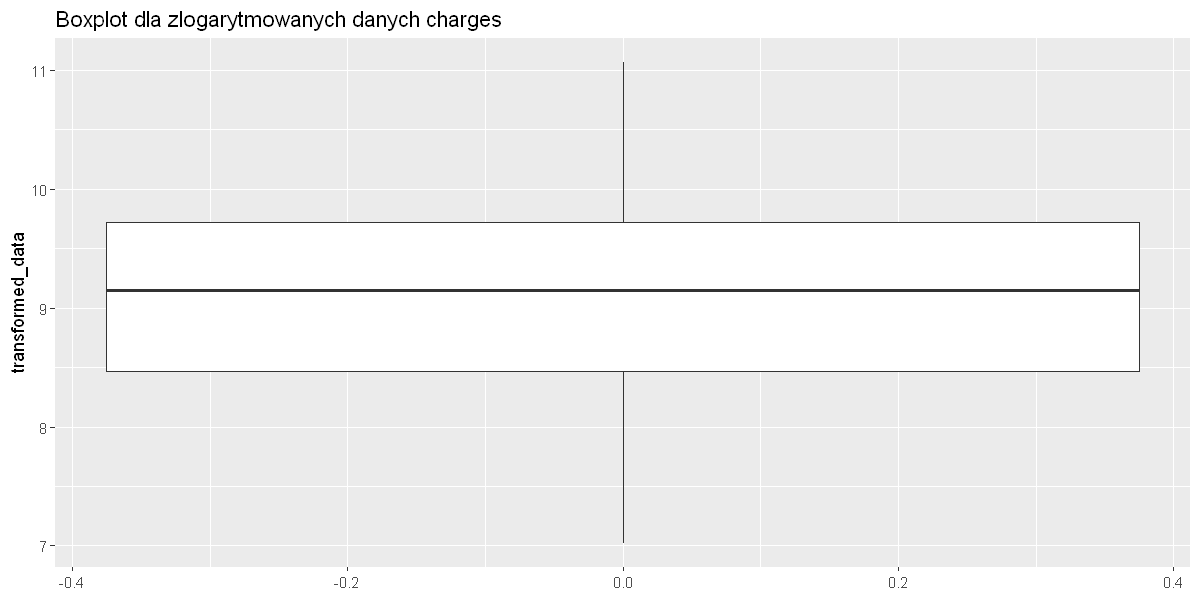

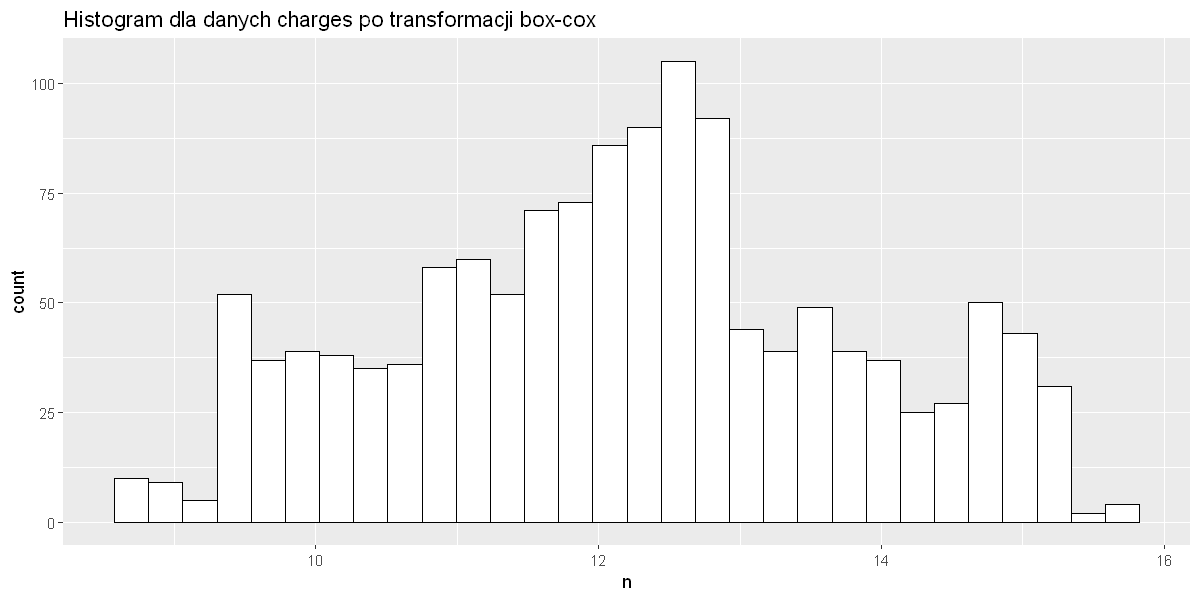

In [481]:
options(repr.plot.width=10, repr.plot.height=5)
transformed_data=log(data$charges)
histogram = ggplot(data, aes(transformed_data)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla zlogarytmowanych danych charges")
histogram
bp=ggplot(data, aes(y=transformed_data)) + 
  geom_boxplot() + ggtitle("Boxplot dla zlogarytmowanych danych charges")
bp
shapiro.test(transformed_data)
n <- (x ^ lambda - 1) / lambda
shapiro.test(n)
histogram = ggplot(data, aes(n)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych charges po transformacji box-cox")
histogram


Po tranformacji dane na wykresach wyglądają tak, jakby pochodziły z rozkładu normalnego, lecz test Shapiro-Wilka wskazuje na to, że musimy odrzucić hipotezę zerową o tym, że dane należą do rozkładu normalnego. Użycie dokładnej wartości lambda z tranformacji Box-Cox też nie pomogło w przekształceniu danych do rozkładu normalnego.

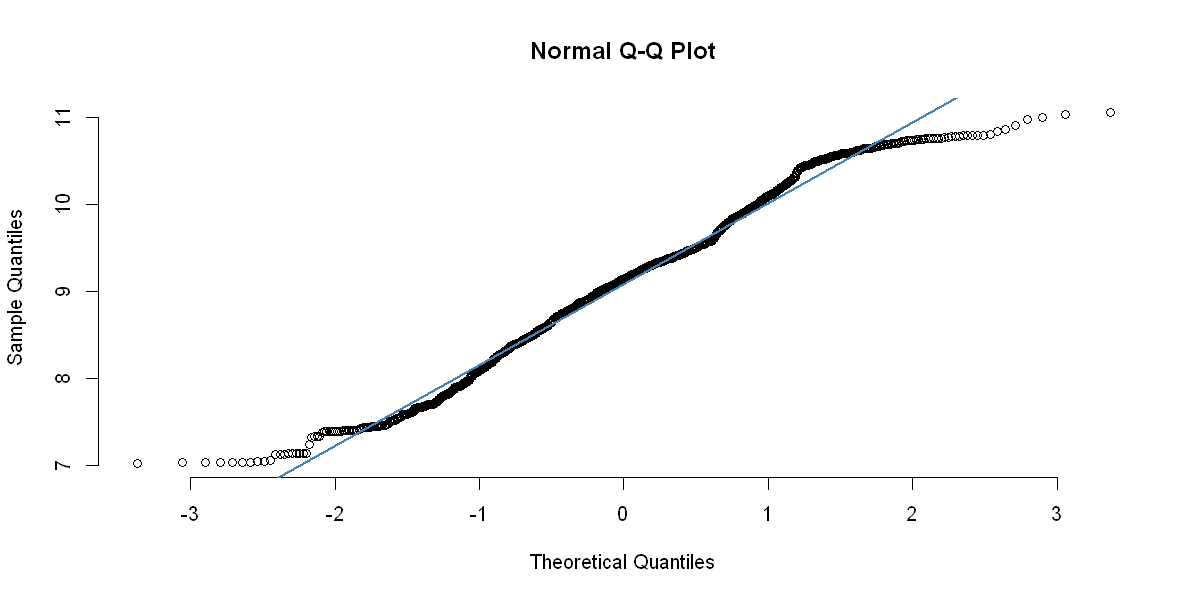

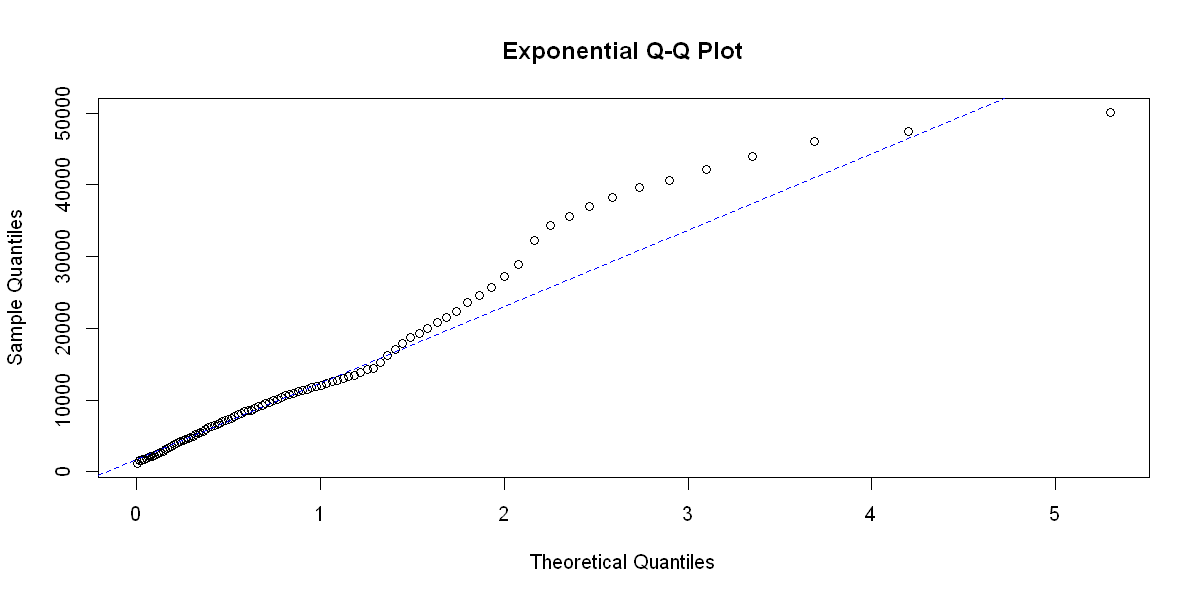

In [266]:
qqnorm(transformed_data, pch = 1, frame = FALSE) 
qqline(transformed_data, col = "steelblue", lwd = 2)
p <- ppoints(100)    # 100 equally spaced points on (0,1), excluding endpoints
q <- quantile(data$charges,p=p)
plot(qexp(p) ,q, main="Exponential Q-Q Plot",
     xlab="Theoretical Quantiles",ylab="Sample Quantiles")
qqline(q, distribution=qexp,col="blue", lty=2)

QQ-plot ujawnia to, że reszty nie mają rozkładu normalnego, występuje tzw "heavy tails", czyli w naszych danych mamy dużo obserwacji o wartościach krytycznych. To jest dość logiczne, znając jakie dane mamy, ponieważ w przypadku kosztów ubezpieczenia możliwa jest sytuacja, kiedy mamy dużo osób które płacą bardzo mało. Zrobiono QQ-Plot też dla modelu wykładniczego, i wygląda lepiej niż dla rozkładu normalnego, lecz też reszty nie są całkiem dopasowane do modelu teoretycznego. Ponieważ dane, które chcemy zmodelować - charges - nie należą do rozkładu normalnego, nie można będzie użyć zwykłego moledu liniowego.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 39.20703

[1] 197.4014

[1] 14.04996

[1] 18

[1] 64

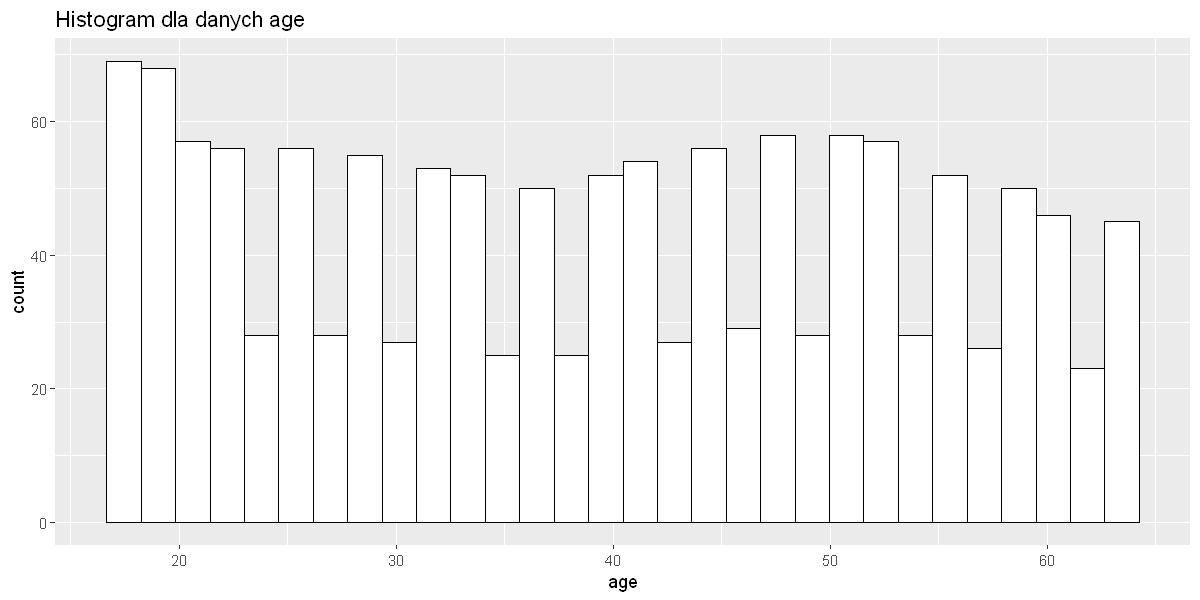

In [482]:
histogram = ggplot(data, aes(age)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych age")
histogram
mean(data$age); var(data$age); sd(data$age); min(data$age); max(data$age)

Dane age mają rozład bliski jednostajnemu na przedziale od 18 do 64, średni wiek wynosi 39 lat

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 30.6634

[1] 37.18788

[1] 6.098187

[1] 15.96

[1] 53.13

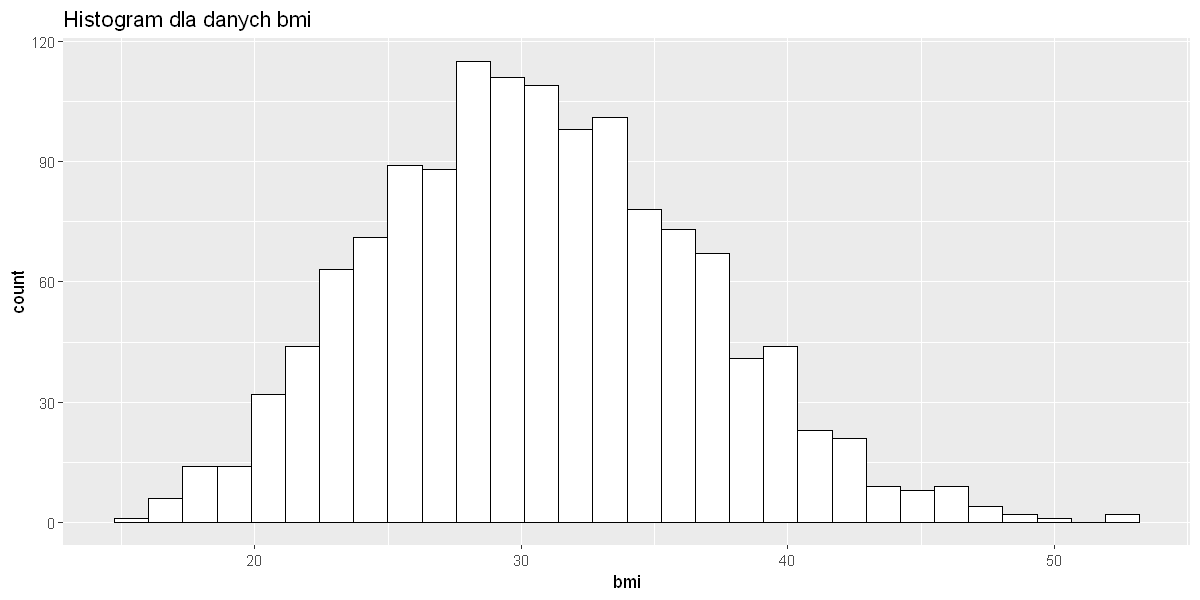

In [483]:
histogram = ggplot(data, aes(bmi)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych bmi")
histogram
mean(data$bmi); var(data$bmi); sd(data$bmi); min(data$bmi); max(data$bmi)

[1] 0.4646465


	Shapiro-Wilk normality test

data:  bmi_transformed
W = 0.99858, p-value = 0.3492


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


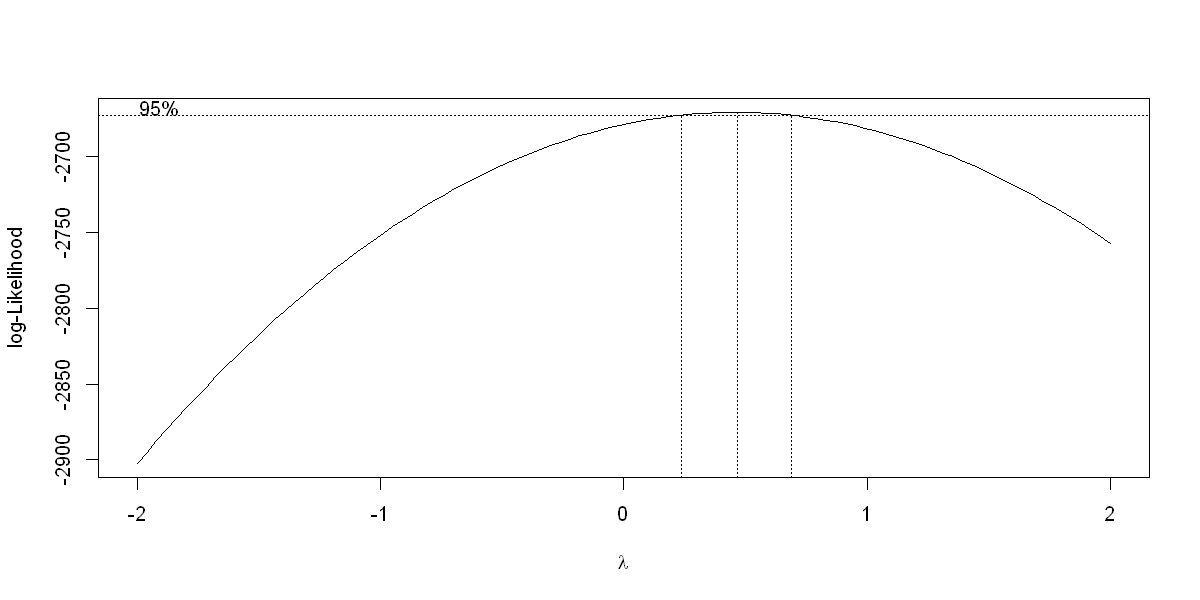

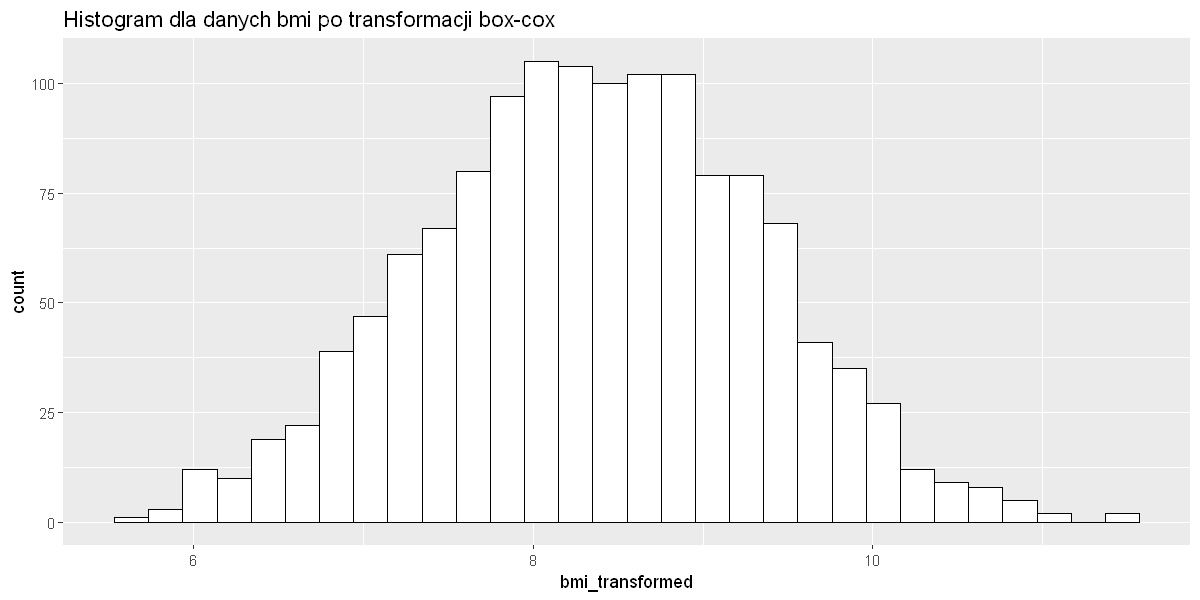

In [486]:
x=data$bmi
library(MASS)
b=boxcox(lm(x ~ 1))
lambda <- b$x[which.max(b$y)]
lambda
bmi_transformed <- (x ^ lambda - 1) / lambda
shapiro.test(bmi_transformed)
histogram = ggplot(data, aes(bmi_transformed)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych bmi po transformacji box-cox")
histogram

Tylko w przypadku danych bmi udało się transformować dane tak, aby miały rozkład normalny

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


[1] 1.094918

[1] 1.453213

[1] 1.205493

[1] 0

[1] 5

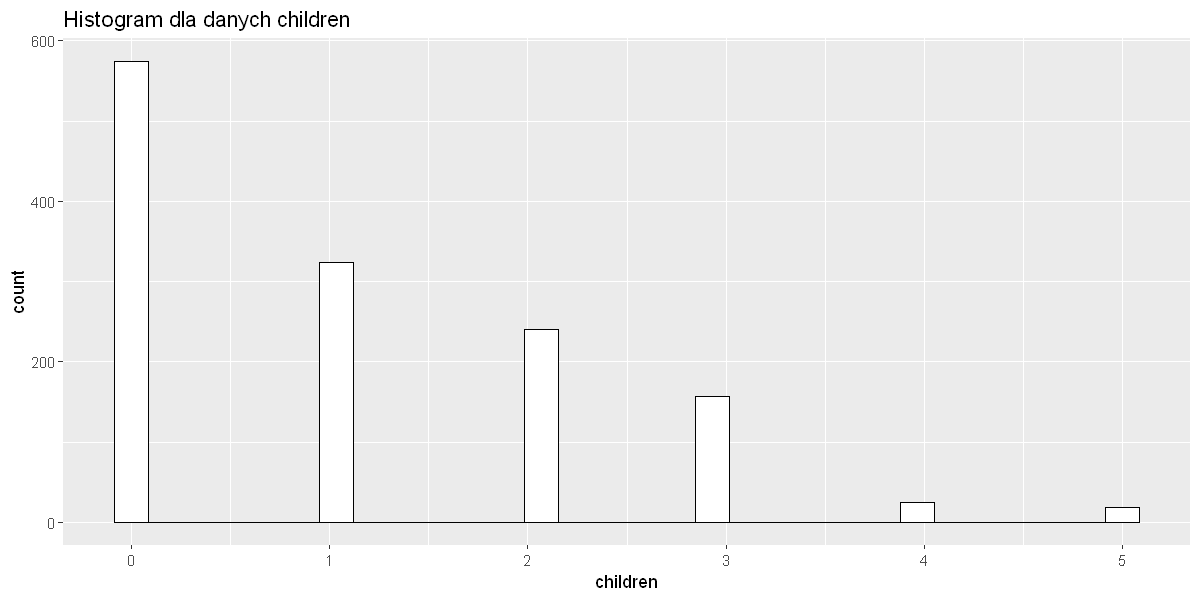

In [484]:
histogram = ggplot(data, aes(children)) + 
  geom_histogram(color="black", fill="white") + ggtitle("Histogram dla danych children")
histogram
mean(data$children); var(data$children); sd(data$children); min(data$children); max(data$children)

Dane children też mogą mieć rozkład wykładniczy

Warning message:
"package 'cowplot' is in use and will not be installed"Warning message:
"Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned."

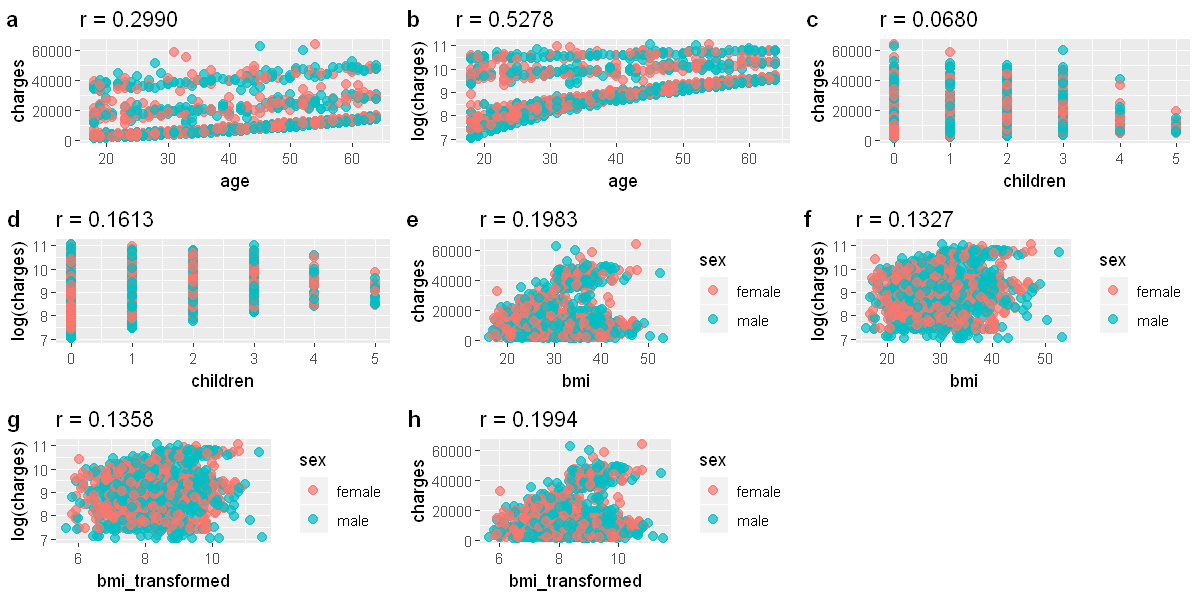

In [513]:
install.packages('cowplot')
library('cowplot')
age.v.charges <- ggplot(data=data, aes(age, charges, color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$age, data$charges))) +
  theme(legend.position = "none")

children.v.charges <- ggplot(data=data, aes(children, charges, color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$children, data$charges))) +
  theme(legend.position = "none")

charges.v.bmi <- ggplot(data=data, aes(bmi, charges, color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$bmi, data$charges)))

age.v.log_charges <- ggplot(data=data, aes(age, log(charges), color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$age, log(data$charges)))) +
  theme(legend.position = "none")

children.v.log_charges <- ggplot(data=data, aes(children, log(charges), color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$children, log(data$charges)))) +
  theme(legend.position = "none")

log_charges.v.bmi <- ggplot(data=data, aes(bmi, log(charges), color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(data$bmi, log(data$charges))))

log_charges.v.transformed_bmi <- ggplot(data=data, aes(bmi_transformed, log(charges), color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(bmi_transformed, log(data$charges))))

charges.v.transformed_bmi <- ggplot(data=data, aes(bmi_transformed, charges, color=sex)) +
  geom_point(size=2.5, alpha=0.7) +
  ggtitle(sprintf("r = %.4f", cor(bmi_transformed, data$charges)))


plot_grid(age.v.charges, age.v.log_charges, children.v.charges, children.v.log_charges, align="hv",
          charges.v.bmi, log_charges.v.bmi, log_charges.v.transformed_bmi, charges.v.transformed_bmi, labels="auto", ncol=3)

Z analizy danych wynika, że pochodzą z różnych rozkładów, dane charges mają wartości dużo wartości eksptemalnych, i daltego nie udało się je stranformować tak, aby miały rozkład normalny, lecz wizualnie po tranformacji logarytmicznej rozkład danych jest bardziej podobny do rozkładu normalnego. W przypadku korelacji istnieje większa korelacji jeżeli używa się dane log(charges) w korelacji z danymi age i children, w przypadku danych bmi przy użyciu log(charges) korelacja maleje. Podczas budowania modelu zrobię model liniowy dla stranformowanych danych charges i tez rozkład gamma dla danych charges nietranformowanych i porównam, który model jest lepszy.


Call:
lm(formula = log(data$charges) ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.07186 -0.19835 -0.04917  0.06598  2.16636 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      7.0305581  0.0723960  97.112  < 2e-16 ***
age              0.0345816  0.0008721  39.655  < 2e-16 ***
sexmale         -0.0754164  0.0244012  -3.091 0.002038 ** 
bmi              0.0133748  0.0020960   6.381 2.42e-10 ***
children         0.1018568  0.0100995  10.085  < 2e-16 ***
smokeryes        1.5543228  0.0302795  51.333  < 2e-16 ***
regionnorthwest -0.0637876  0.0349057  -1.827 0.067860 .  
regionsoutheast -0.1571967  0.0350828  -4.481 8.08e-06 ***
regionsouthwest -0.1289522  0.0350271  -3.681 0.000241 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4443 on 1329 degrees of freedom
Multiple R-squared:  0.7679,	Adjusted R-squared:  0.7666 
F-statistic: 549.8 on 8 and 1329 DF,  p-value: < 2

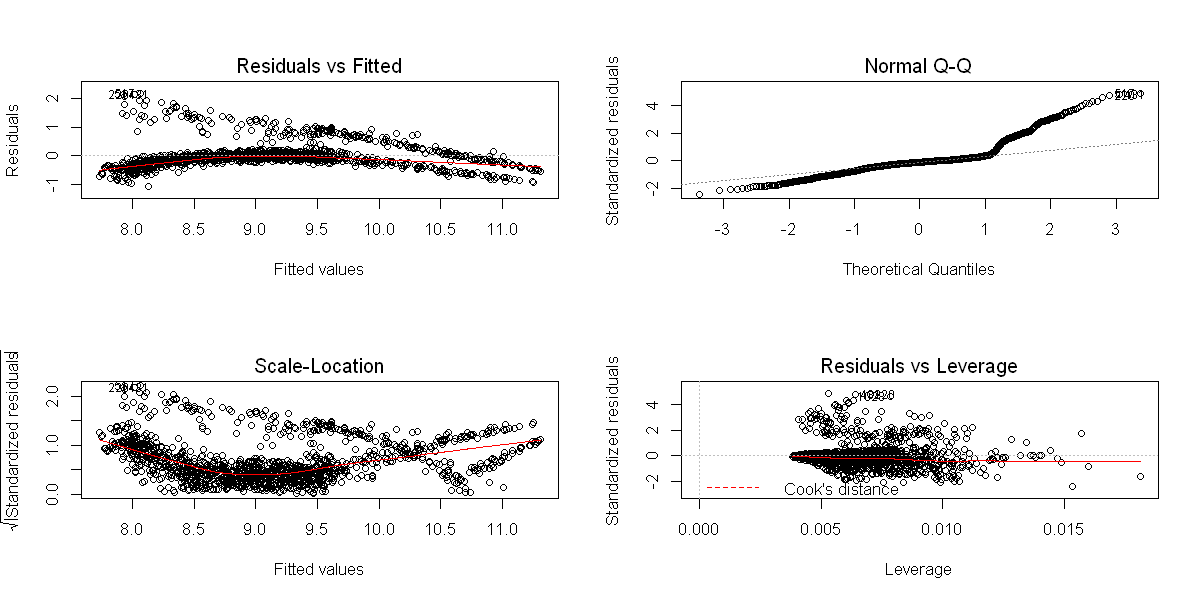

In [456]:
options(repr.plot.width=10, repr.plot.height=5)
liniowy=lm(formula = log(data$charges)~., data=data)
summary(liniowy)
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(2, 2));
plot(liniowy)

Ponieważ moje dane nie mają rozkłądu normalnego, nie mogę zastosować ANOVY do analizy interakcji, stosuję model bez interakcji.

In [522]:
summary(aov(log(data$charges) ~ data$age * data$bmi, data = data))
summary(aov(log(data$charges) ~ data$age * data$children, data = data))
summary(aov(log(data$charges) ~ data$age * data$region, data = data))
summary(aov(log(data$charges) ~ data$age * data$smoker, data = data))
summary(aov(log(data$charges) ~ data$age * data$sex, data = data))

summary(aov(log(data$charges) ~ data$bmi * data$children, data = data))
summary(aov(log(data$charges) ~ data$bmi * data$region, data = data))
summary(aov(log(data$charges) ~ data$bmi * data$smoker, data = data))
summary(aov(log(data$charges) ~ data$bmi * data$sex, data = data))

summary(aov(log(data$charges) ~ data$children * data$region, data = data))
summary(aov(log(data$charges) ~ data$children * data$smoker, data = data))
summary(aov(log(data$charges) ~ data$children * data$sex, data = data))

summary(aov(log(data$charges) ~ data$smoker * data$sex, data = data))
summary(aov(log(data$charges) ~ data$smoker * data$region, data = data))

                    Df Sum Sq Mean Sq F value  Pr(>F)    
data$age             1  315.0  314.96 520.047 < 2e-16 ***
data$bmi             1    6.4    6.43  10.624 0.00114 ** 
data$age:data$bmi    1    1.2    1.16   1.915 0.16662    
Residuals         1334  807.9    0.61                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                         Df Sum Sq Mean Sq F value  Pr(>F)    
data$age                  1  315.0  314.96 532.119 < 2e-16 ***
data$children             1   21.9   21.86  36.925 1.6e-09 ***
data$age:data$children    1    4.1    4.07   6.871 0.00886 ** 
Residuals              1334  789.6    0.59                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       Df Sum Sq Mean Sq F value Pr(>F)    
data$age                1  315.0  314.96 517.626 <2e-16 ***
data$region             3    4.0    1.35   2.215 0.0846 .  
data$age:data$region    3    2.2    0.73   1.208 0.3055    
Residuals            1330  809.3    0.61                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       Df Sum Sq Mean Sq F value Pr(>F)    
data$age                1  315.0   315.0  1666.9 <2e-16 ***
data$smoker             1  521.1   521.1  2757.8 <2e-16 ***
data$age:data$smoker    1   42.4    42.4   224.3 <2e-16 ***
Residuals            1334  252.1     0.2                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    Df Sum Sq Mean Sq F value Pr(>F)    
data$age             1  315.0  314.96 515.661 <2e-16 ***
data$sex             1    0.3    0.31   0.513  0.474    
data$age:data$sex    1    0.4    0.41   0.669  0.414    
Residuals         1334  814.8    0.61                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                         Df Sum Sq Mean Sq F value   Pr(>F)    
data$bmi                  1   19.9  19.898  24.538 8.22e-07 ***
data$children             1   28.8  28.816  35.536 3.20e-09 ***
data$bmi:data$children    1    0.0   0.010   0.013     0.91    
Residuals              1334 1081.7   0.811                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       Df Sum Sq Mean Sq F value   Pr(>F)    
data$bmi                1   19.9  19.898  24.055 1.05e-06 ***
data$region             3    5.1   1.706   2.063   0.1034    
data$bmi:data$region    3    5.3   1.770   2.139   0.0935 .  
Residuals            1330 1100.1   0.827                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       Df Sum Sq Mean Sq F value   Pr(>F)    
data$bmi                1   19.9    19.9   44.37 3.96e-11 ***
data$smoker             1  499.9   499.9 1114.83  < 2e-16 ***
data$bmi:data$smoker    1   12.4    12.4   27.66 1.68e-07 ***
Residuals            1334  598.2     0.4                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                    Df Sum Sq Mean Sq F value  Pr(>F)    
data$bmi             1   19.9   19.90  23.968 1.1e-06 ***
data$sex             1    0.0    0.00   0.000  0.9847    
data$bmi:data$sex    1    3.1    3.11   3.746  0.0532 .  
Residuals         1334 1107.5    0.83                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                            Df Sum Sq Mean Sq F value   Pr(>F)    
data$children                1   29.4  29.426  35.756 2.87e-09 ***
data$region                  3    4.3   1.450   1.762    0.153    
data$children:data$region    3    2.2   0.726   0.883    0.449    
Residuals                 1330 1094.5   0.823                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                            Df Sum Sq Mean Sq F value   Pr(>F)    
data$children                1   29.4    29.4   65.73 1.16e-15 ***
data$smoker                  1  498.9   498.9 1114.38  < 2e-16 ***
data$children:data$smoker    1    5.0     5.0   11.23 0.000826 ***
Residuals                 1334  597.2     0.4                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                         Df Sum Sq Mean Sq F value   Pr(>F)    
data$children             1   29.4  29.426  35.654 3.02e-09 ***
data$sex                  1    0.0   0.009   0.011    0.916    
data$children:data$sex    1    0.1   0.066   0.080    0.778    
Residuals              1334 1101.0   0.825                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                       Df Sum Sq Mean Sq  F value Pr(>F)    
data$smoker             1  500.7   500.7 1068.539 <2e-16 ***
data$sex                1    2.3     2.3    4.929 0.0266 *  
data$smoker:data$sex    1    2.4     2.4    5.140 0.0235 *  
Residuals            1334  625.1     0.5                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                          Df Sum Sq Mean Sq  F value Pr(>F)    
data$smoker                1  500.7   500.7 1069.690 <2e-16 ***
data$region                3    2.5     0.8    1.764  0.152    
data$smoker:data$region    3    4.8     1.6    3.408  0.017 *  
Residuals               1330  622.5     0.5                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Zrobiono analizę interakcji dla par danych za pomocą ANOVA, dane charges nie mają rozkładu normalnego, ale reszty są zbliżone do rozkładu normalnego, lecz znów przez nie spełnienie założania normalności test ANOVA może mieć mniejszą moc


Call:
lm(formula = log(data$charges) ~ . + age * children + smoker * 
    region + smoker * sex + children * smoker + bmi * smoker + 
    age * smoker, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56735 -0.15875 -0.08223 -0.00662  2.43601 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                6.9948811  0.0722093  96.870  < 2e-16 ***
age                        0.0445976  0.0009704  45.957  < 2e-16 ***
sexmale                   -0.1092697  0.0231358  -4.723 2.57e-06 ***
bmi                        0.0018270  0.0020124   0.908   0.3641    
children                   0.2875961  0.0275189  10.451  < 2e-16 ***
smokeryes                  1.3188880  0.1488254   8.862  < 2e-16 ***
regionnorthwest           -0.0691396  0.0329161  -2.100   0.0359 *  
regionsoutheast           -0.1589316  0.0338319  -4.698 2.91e-06 ***
regionsouthwest           -0.1826014  0.0329900  -5.535 3.75e-08 ***
age:children             

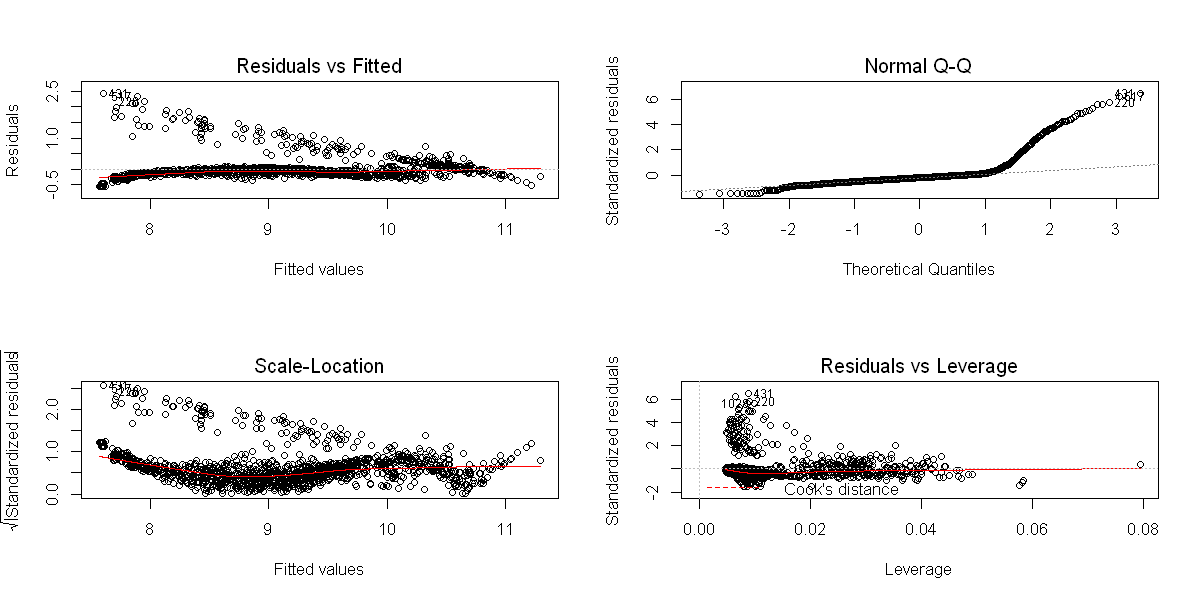

In [527]:
options(repr.plot.width=10, repr.plot.height=5)
liniowy1=lm(formula = log(data$charges)~.+age*children+smoker*region+smoker*sex+children*smoker+bmi*smoker+age*smoker, data=data)
summary(liniowy1)
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(2, 2));
plot(liniowy1)

In [531]:
AIC(liniowy)
AIC(liniowy1)
anova(liniowy, liniowy1)

[1] 1637.033

[1] 1201.561

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1329,262.3290,NA,NA,NA,NA
1321,187.1997,8,75.12931,66.27004,1.865283e-91


Za pomocą uwzględnienia analizy interakcji udało się polepszyć model, modele bez interakcji i z interakcją są istotnie różne. Teraz sprawdzimy, czy model zawiera dane odstajające i wpływowe:

In [532]:
influences <- influence.measures(liniowy)
wplywowe=which(apply(influences$is.inf, 1, any))


,age,sex,bmi,children,smoker,region,charges
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622
7,46,female,33.440,1,no,southeast,8240.590
8,37,female,27.740,3,no,northwest,7281.506
9,37,male,29.830,2,no,northeast,6406.411
11,25,male,26.220,0,no,northeast,2721.321


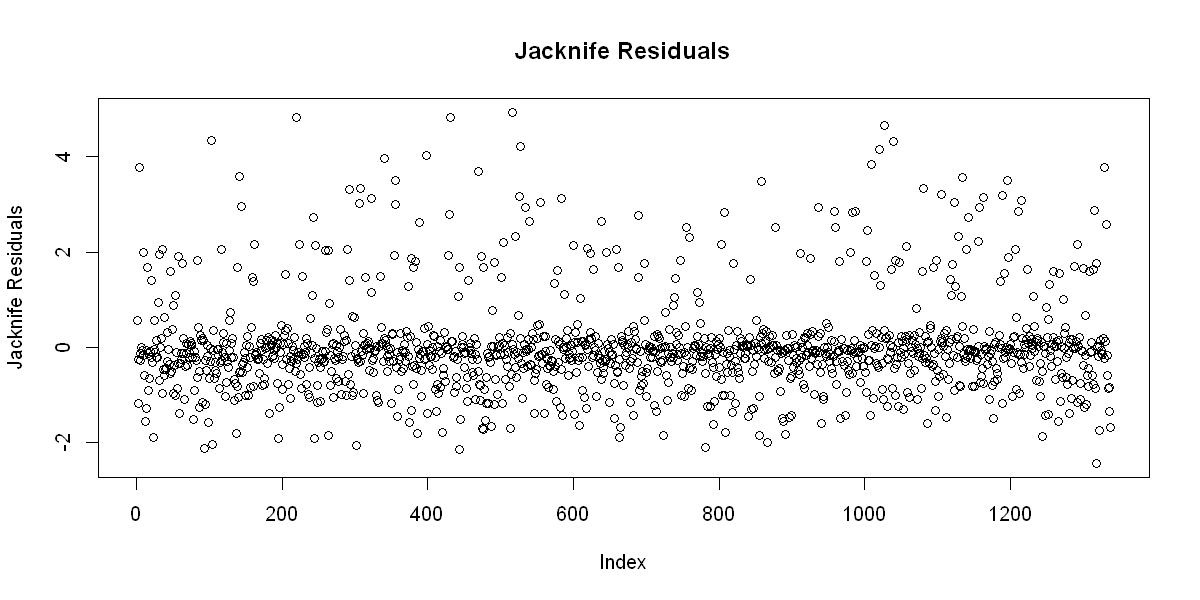

In [534]:
jack = rstudent(liniowy)
plot(jack, ylab="Jacknife Residuals", main="Jacknife Residuals")
outliers <- which(abs(jack) > 2)
library(dplyr)
outliers_nie_wplywowe=outliers[! outliers %in% c(wplywowe)]
data_without_outliers <- data[-c(outliers_nie_wplywowe),]
data_without_outliers



Call:
lm(formula = log(data_without_outliers$charges) ~ . + age * children + 
    smoker * region + smoker * sex + children * smoker + bmi * 
    smoker + age * smoker, data = data_without_outliers)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58255 -0.15322 -0.07553 -0.00363  2.42595 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                6.9980596  0.0716803  97.629  < 2e-16 ***
age                        0.0441375  0.0009712  45.445  < 2e-16 ***
sexmale                   -0.1043837  0.0230160  -4.535 6.29e-06 ***
bmi                        0.0020593  0.0020037   1.028   0.3042    
children                   0.2927568  0.0276159  10.601  < 2e-16 ***
smokeryes                  1.2876862  0.1484071   8.677  < 2e-16 ***
regionnorthwest           -0.0720521  0.0327482  -2.200   0.0280 *  
regionsoutheast           -0.1558602  0.0336687  -4.629 4.04e-06 ***
regionsouthwest           -0.1795508  0.0327590  -5.481 5.08

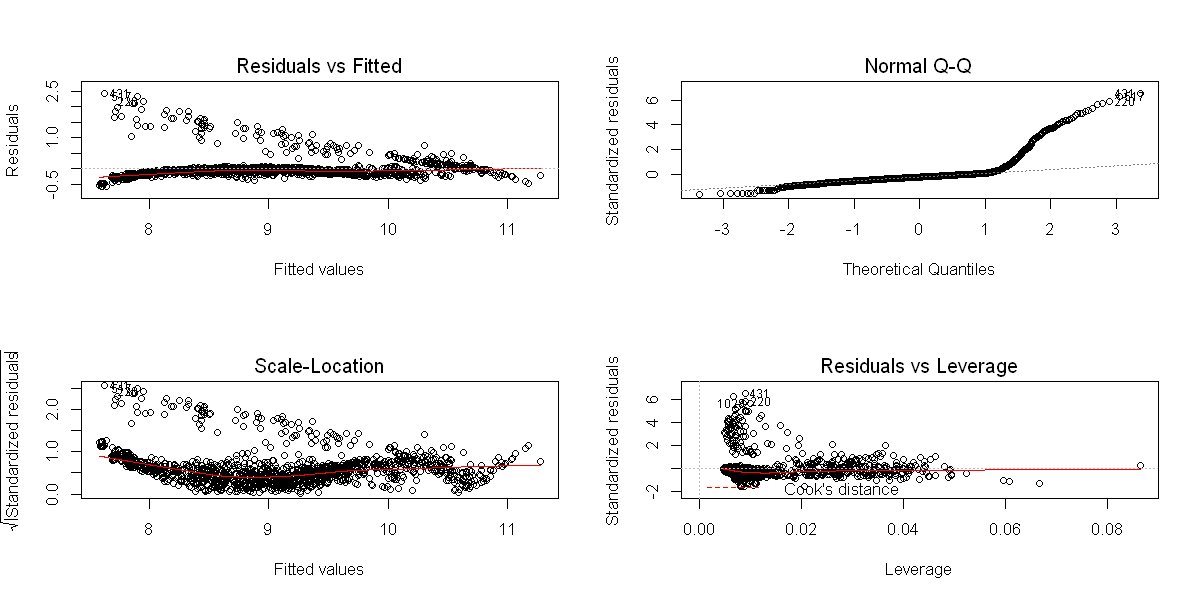

In [535]:
liniowy2=lm(formula = log(data_without_outliers$charges)~.+age*children+smoker*region+smoker*sex+children*smoker+bmi*smoker+age*smoker, data=data_without_outliers)
summary(liniowy2)
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(2, 2));
plot(liniowy2)


In [584]:
predykcja=data[1, 1:6]
x=predict(liniowy2, newdata=predykcja, level = 0.95, interval = "confidence")
exp(x)
x=predict(liniowy1, newdata=predykcja, level = 0.95, interval = "confidence")
exp(x)
x=predict(liniowy, newdata=predykcja, level = 0.95, interval = "confidence")
exp(x)
data[1, 7]


fit,lwr,upr
19968.92,17395.27,22923.36


fit,lwr,upr
20695.44,18111.53,23648


fit,lwr,upr
13175.8,12111.07,14334.14


[1] 16884.92

In [536]:
AIC(liniowy)
AIC(liniowy1)
AIC(liniowy2)

[1] 1637.033

[1] 1201.561

[1] 1153.414

Z analizy AIC widać, że po usunięciu danych odstajających nie wpływowych udało się jeszcze bardziej poprawić ten model (AIC dla ostatniego modelu jest najniższe). Lecz z diagnostyki graficznej tych modeli widać, że modele te nie są najlepsze, reszty w tych modelach nie mają rozkładu normalnego, jest więcej reszt powyżej zera, więc model ten może trochę zawyżać swoje predykcje. Spróbowano zrobić predykcję dla danych z pierwszego rzędu naszyh danych, i predykcja zrobiona z zastosowaniem modeli liniowy1 i liniowy2 zwraca trochę większą wartość, niż rzeczywista. Przyczyną mogą być heavy tails na QQ-Plot, które wskazują na to, że jest dużo wartości ekstremalnych.

Ponieważ rozkładu kwantyli (QQ-Plot) dla rozkładu wykładniczego był podobny do rozkładu kwantyli naszych danych zrobimy model na podstawie rozkładu gamma:

In [546]:
model1=glm(formula = data$charges~., family="Gamma", data = data)
summary(model1, dispersion=1)


Call:
glm(formula = data$charges ~ ., family = "Gamma", data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.48397  -0.48833  -0.08737   0.21243   1.74444  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.932e-04  1.000e-05  19.308  < 2e-16 ***
age             -9.693e-07  1.205e-07  -8.042 8.84e-16 ***
sexmale          1.224e-06  3.004e-06   0.407   0.6837    
bmi             -1.133e-06  2.564e-07  -4.417 9.99e-06 ***
children        -2.157e-06  1.290e-06  -1.672   0.0945 .  
smokeryes       -8.207e-05  4.139e-06 -19.828  < 2e-16 ***
regionnorthwest  1.786e-06  4.406e-06   0.405   0.6852    
regionsoutheast  4.282e-06  3.969e-06   1.079   0.2806    
regionsouthwest  2.918e-06  4.331e-06   0.674   0.5004    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 1)

    Null deviance: 1056.0  on 1337  degrees of freedom
Residual deviance:  478

In [547]:
model2=step(model1, trace=0)

In [548]:
summary(model2, dispersion=1)


Call:
glm(formula = data$charges ~ age + bmi + children + smoker, family = "Gamma", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4870  -0.4916  -0.0861   0.2110   1.7383  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.935e-04  9.437e-06  20.500  < 2e-16 ***
age         -9.687e-07  1.193e-07  -8.117 4.78e-16 ***
bmi         -1.047e-06  2.398e-07  -4.366 1.27e-05 ***
children    -2.274e-06  1.270e-06  -1.791   0.0733 .  
smokeryes   -8.187e-05  4.129e-06 -19.827  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 1)

    Null deviance: 1056.04  on 1337  degrees of freedom
Residual deviance:  480.11  on 1333  degrees of freedom
AIC: 26865

Number of Fisher Scoring iterations: 6


In [550]:
AIC(model1)
AIC(model2)
anova(model1, model2, test="LRT")

[1] 26869.27

[1] 26865.43

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
1329,478.6984,NA,NA,NA
1333,480.1085,-4,-1.410064,0.4545234


In [551]:
model3=glm(formula = data$charges~.+age*children+smoker*region+smoker*sex+children*smoker+bmi*smoker+age*smoker, family="Gamma", data = data)
summary(model3, dispersion=1)


Call:
glm(formula = data$charges ~ . + age * children + smoker * region + 
    smoker * sex + children * smoker + bmi * smoker + age * smoker, 
    family = "Gamma", data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.03828  -0.27142  -0.11059  -0.00349   2.65779  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                3.137e-04  2.335e-05  13.435  < 2e-16 ***
age                       -4.167e-06  3.061e-07 -13.615  < 2e-16 ***
sexmale                    4.884e-06  6.569e-06   0.743 0.457222    
bmi                       -7.165e-08  5.815e-07  -0.123 0.901942    
children                  -1.816e-05  5.869e-06  -3.095 0.001970 ** 
smokeryes                 -2.251e-04  2.515e-05  -8.947  < 2e-16 ***
regionnorthwest            6.609e-06  8.737e-06   0.756 0.449382    
regionsoutheast            1.255e-05  9.260e-06   1.355 0.175499    
regionsouthwest            1.487e-05  9.266e-06   1.605 0.10

In [552]:
model4=glm(formula = data$charges~age+children+smoker+children*smoker+bmi*smoker+age*smoker, family="Gamma", data = data)
summary(model4, dispersion=1)


Call:
glm(formula = data$charges ~ age + children + smoker + children * 
    smoker + bmi * smoker + age * smoker, family = "Gamma", data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.07818  -0.26913  -0.10325  -0.00769   2.60314  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         3.084e-04  2.123e-05  14.525  < 2e-16 ***
age                -4.008e-06  2.776e-07 -14.437  < 2e-16 ***
children           -9.815e-06  2.401e-06  -4.089 4.34e-05 ***
smokeryes          -2.272e-04  2.362e-05  -9.620  < 2e-16 ***
bmi                 1.625e-07  5.590e-07   0.291 0.771311    
children:smokeryes  9.660e-06  2.884e-06   3.350 0.000809 ***
smokeryes:bmi      -1.377e-06  6.107e-07  -2.254 0.024168 *  
age:smokeryes       3.751e-06  3.055e-07  12.280  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to be 1)

    Null deviance: 1056.04  on 13

In [553]:
AIC(model1)
AIC(model2)
AIC(model3)
AIC(model4)

[1] 26869.27

[1] 26865.43

[1] 26290.82

[1] 26300.96

In [554]:
n = length(data$charges)

In [555]:
influences <- influence.measures(model2)
wplywowe=which(apply(influences$is.inf, 1, any))

243 
2.910093

78  139  182  290  400  479  601  841  889  899 1212 1249 1259 1336 
  78  139  182  290  400  479  601  841  889  899 1212 1249 1259 1336

,age,sex,bmi,children,smoker,region,charges
1,19,female,27.900,0,yes,southwest,16884.924
2,18,male,33.770,1,no,southeast,1725.552
3,28,male,33.000,3,no,southeast,4449.462
4,33,male,22.705,0,no,northwest,21984.471
5,32,male,28.880,0,no,northwest,3866.855
6,31,female,25.740,0,no,southeast,3756.622
7,46,female,33.440,1,no,southeast,8240.590
8,37,female,27.740,3,no,northwest,7281.506
9,37,male,29.830,2,no,northeast,6406.411
10,60,female,25.840,0,no,northwest,28923.137


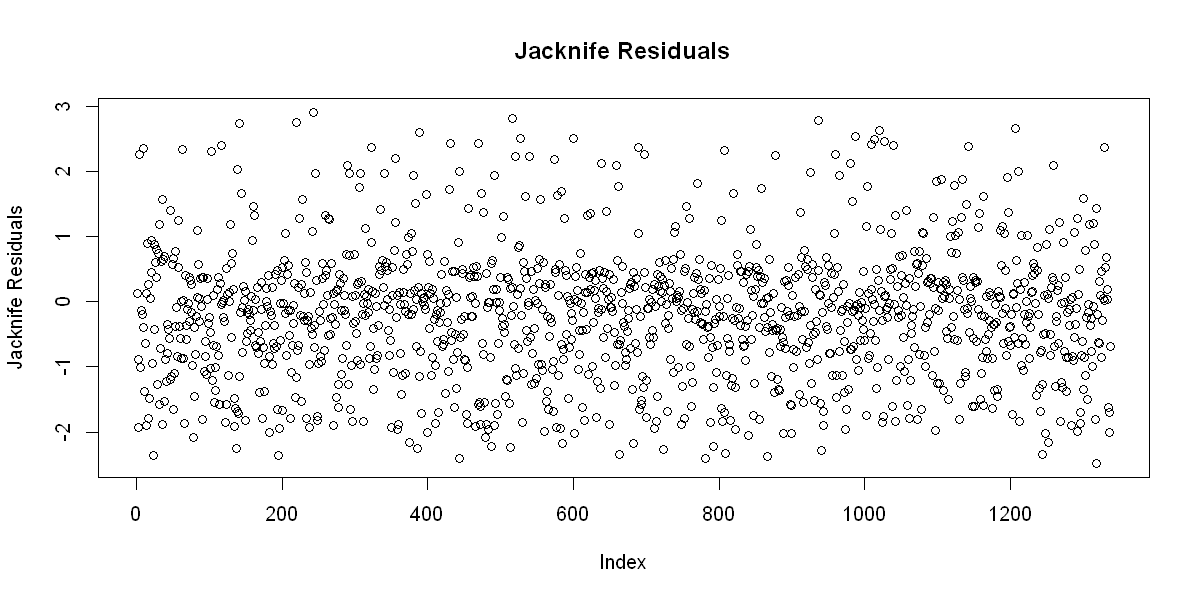

In [556]:
jack = rstudent(model2) #pozwala znajdywac obserwacje odstajace
jack[which.max(abs(jack))]
plot(jack, ylab="Jacknife Residuals", main="Jacknife Residuals")
outliers <- which(abs(jack) > 2)
library(dplyr)
outliers_nie_wplywowe=outliers[! outliers %in% c(wplywowe)]
outliers_nie_wplywowe
data_without_outliers <- data[-c(outliers_nie_wplywowe),]
data_without_outliers

In [560]:
model5=glm(formula = data_without_outliers$charges~age+children+smoker+children*smoker+bmi*smoker+age*smoker, family="Gamma", data = data_without_outliers)
summary(model5, dispersion=1)


Call:
glm(formula = data_without_outliers$charges ~ age + children + 
    smoker + children * smoker + bmi * smoker + age * smoker, 
    family = "Gamma", data = data_without_outliers)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.08467  -0.26679  -0.10036  -0.00834   2.58377  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         3.063e-04  2.141e-05  14.306  < 2e-16 ***
age                -3.944e-06  2.811e-07 -14.027  < 2e-16 ***
children           -9.111e-06  2.464e-06  -3.698 0.000218 ***
smokeryes          -2.251e-04  2.378e-05  -9.467  < 2e-16 ***
bmi                 1.043e-07  5.652e-07   0.185 0.853617    
children:smokeryes  8.955e-06  2.937e-06   3.049 0.002293 ** 
smokeryes:bmi      -1.319e-06  6.164e-07  -2.139 0.032420 *  
age:smokeryes       3.687e-06  3.087e-07  11.944  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for Gamma family taken to b

In [563]:
AIC(model1)
AIC(model2)
AIC(model3)
AIC(model4)
anova(model1, model3, test="LRT")
AIC(model5)

[1] 26869.27

[1] 26865.43

[1] 26290.82

[1] 26300.96

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
1329,478.6984,NA,NA,NA
1321,313.3181,8,165.3804,1.296113e-77


[1] 26018.71

In [586]:
predykcja=data[1, 1:6]
x=predict(model5, newdata=predykcja, type="response")
exp(x)
data[1, 7]

1 
Inf

[1] 16884.92

Nie udało się zrobić predykcji na podstawie tego modelu, co wskazuje na to, że nie jest dobry w tym przypadku

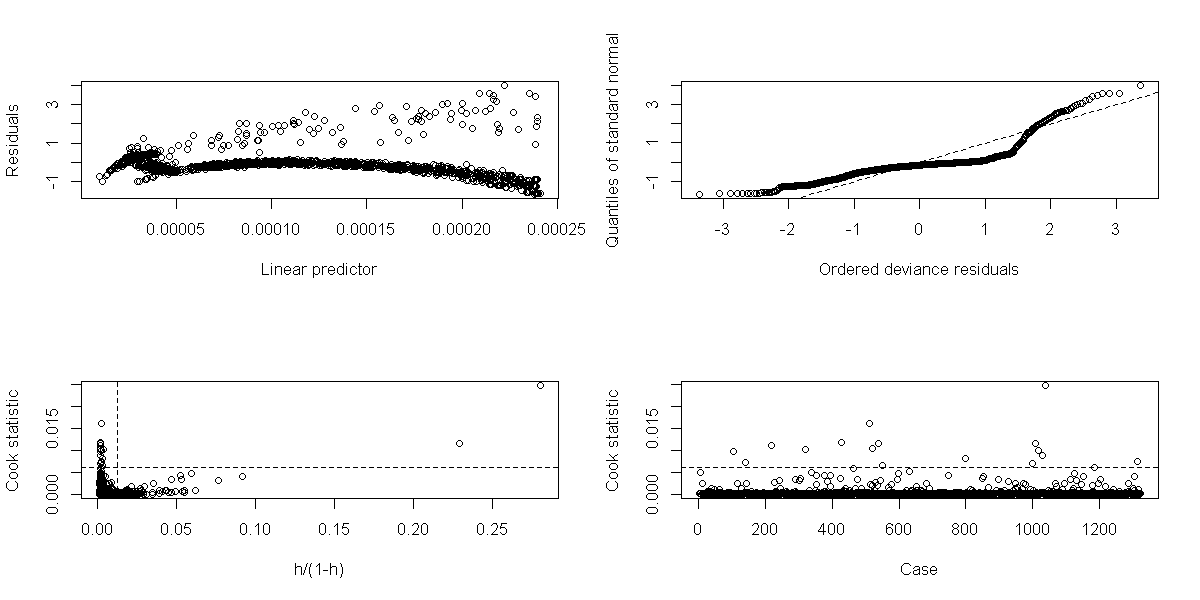

In [570]:
library(boot)
diag <- glm.diag(model5)
glm.diag.plots(model5, diag)

Po dodaniu do modelu interakcji i usunięciu wartości odstajających nie wspływowych udało się znacząco polepszyć też ten model, lecz znów jeżeli zrobimy diagnoże wizualną, to zobaczymy, że model nie jest idealny.

Podsumowując, zbudowano dwa różne modele, liniowy i uogólniony liniowy. W obu przypadkach dodano interakcję i usunięto dane ostajające, co znacząco poprawiło oba modele, lecz diagnoza wiazualna obu modeli wskazuje na to, że założenia do stosowania tych modeli nie są do końca spełnione (np. w przypadku modelu liniowego dane nasze nie mieli rozkładu normalnego), więc nie będą dawać bardzo precyzyjnych predykcji. Biorąc pod uwagę dwa te typy modeli, lepszym modelem jest model liniowy, ponieważ ma znacznie mniejsze AIC niż model uogólniony liniowy.